# Анализ московского рынка общественного питания

Есть идея открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой.

Задача — изучить текущее положение дел на рынке, оценить, возможно ли удержаться на рынке после спадения эффекта новизны от роботов-официантов.

## Описание данных

**Таблица `rest_data`:**
- `id` — идентификатор объекта;
- `object_name` — название объекта общественного питания;
- `chain` — сетевой ресторан;
- `object_type` — тип объекта общественного питания;
- `address` — адрес;
- `number` — количество посадочных мест.

**Презентация: https://yadi.sk/i/1WIA0snz3eG4sw**

## Структура работы

1. [Загрузка данных и первый взгляд](#data_import)
    - [Вывод](#sum_up_1)
2. [Анализ данных](#analysis)
    - [Cоотношение видов объектов общественного питания по количеству](#object_types_n)
    - [Соотношение сетевых и не сетевых заведений](#chain_vs_notchain)
    - [Типичные сети](#typical_chain)
    - [Посадочные места](#seats)
    - [Насыщенность заведениями по улицам](#volume)
    - [Вместительность заведений популярных улиц](#top_streets_capacity)
3. [Общий вывод](#sum_up)

<a id="data_import"></a>
## Загрузка данных и первый взгляд

Загрузим данные и проверим, верно ли определились типы переменных, есть ли пропуски и дубликаты.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
import plotly.figure_factory as ff

In [2]:
rest_data = pd.read_csv('rest_data.csv')

In [3]:
rest_data.head(10)

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
5,27429,СТОЛ. ПРИ ГОУ СОШ № 1051,нет,столовая,"город Москва, Абрамцевская улица, дом 15, корп...",240
6,148815,Брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10
7,20957,Буфет МТУСИ,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",90
8,20958,КПФ СЕМЬЯ-1,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",150
9,28858,Столовая МТУСИ,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",120


In [4]:
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


В таблице более 15 тыс. наблюдений. Типы данных определены верно: id и количество посадочных мест целочисленные, остальные переменные - строковые значения.

In [5]:
rest_data['chain'].unique()

array(['нет', 'да'], dtype=object)

В переменной `chain` два возможных значения, все в порядке.

Приведем названия заведений к нижнему регистру, чтобы не пропустить возможные дубликаты.

In [6]:
rest_data['object_name_lower'] = rest_data['object_name'].str.lower()

In [7]:
rest_data[['object_name_lower', 'address', 'number']].duplicated().sum()

93

In [8]:
rest_data[['object_name_lower', 'address']].duplicated().sum()

225

В базе 225 наблюдений с дублирующимся адресом и названием и всего 93 дубликата, если добавить информацию о количестве мест. Избавимся от дубликатов по названию и расположению, оставим записи с наибольшим `id`, таким образом сохраним наиболее актуальную запись о заведении (исходим из предположения, что одинаковые заведения с разным количеством мест - это записи в базу в разное время, соответственно, запись с максимальным айди будет соответствовать самой свежей информации).

In [9]:
rest_data = rest_data.sort_values(by='id')
rest_data = rest_data.drop_duplicates(subset=['object_name_lower', 'address'], keep='last')

От дубликатов избавились, теперь посмотрим на топ-60 названий сетей.

In [10]:
rest_data[rest_data['chain'] == 'да']['object_name_lower'].value_counts().head(60)

шоколадница                            154
kfc                                    152
макдоналдс                             147
бургер кинг                            136
теремок                                 93
домино'с пицца                          90
крошка картошка                         89
милти                                   72
суши wok                                72
папа джонс                              51
додо пицца                              49
кофе с собой                            42
чайхона №1                              41
якитория                                38
хинкальная                              38
subway                                  34
хлеб насущный                           32
кофе хаус                               32
тануки                                  32
starbucks                               28
прайм стар                              26
cofix                                   25
иль патио                               25
мята lounge

У одних и тех же сетей есть разные варианты написания. Например, *starbucks* и *старбакс*.

In [11]:
len(rest_data[rest_data['object_name_lower'].str.contains('kfc')])

186

In [12]:
len(rest_data[rest_data['object_name_lower'] == 'kfc'])

152

In [13]:
rest_data[rest_data['object_name_lower'].str.contains('kfc')]['object_name_lower'].unique()

array(['ростикс kfc', 'кафе kfc', 'кафе «kfc»', 'kfc',
       'kfc волгоградский', 'предприятие быстрого обслуживания «kfc»',
       'закусочная kfc', 'закусочная «kfc»', 'пбо «kfc»',
       'пбо «kfc покрышкина»', 'kfc.', 'ресторан kfc', 'ресторан «kfc»',
       'fridays kfc', 'ресторан быстрого питания kfc'], dtype=object)

In [14]:
len(rest_data[rest_data['object_name_lower'].str.contains('kfc')]['object_name_lower'].unique())

15

Для сети **kfc** существует **34** записи с нестандартным написанием и **15** вариантов написания. Исправим названия наиболее крупных сетей.

In [15]:
rest_data.loc[rest_data['object_name_lower'].str.contains('kfc'), 'object_name_lower'] = 'kfc'

In [16]:
chains = list(rest_data[rest_data['chain'] == 'да']['object_name_lower'].value_counts().head(30).index)

In [17]:
chains

['kfc',
 'шоколадница',
 'макдоналдс',
 'бургер кинг',
 'теремок',
 "домино'с пицца",
 'крошка картошка',
 'милти',
 'суши wok',
 'папа джонс',
 'додо пицца',
 'кофе с собой',
 'чайхона №1',
 'якитория',
 'хинкальная',
 'subway',
 'хлеб насущный',
 'кофе хаус',
 'тануки',
 'starbucks',
 'прайм стар',
 'иль патио',
 'cofix',
 'му-му',
 'мята lounge',
 'старбакс',
 'сабвей',
 'андерсон',
 'пицца хат',
 'кафе «шоколадница»']

Даже в топ-30 сетях по количеству заведений встречаются различные написания одной и той же сети.

In [18]:
unwanted = {'starbucks', 'старбакс', 'кафе «шоколадница»', 'сабвей', 'subway'}
chains = [i for i in chains if i not in unwanted]

In [19]:
for i in chains:
    rest_data.loc[rest_data['object_name_lower'].str.contains(i), 'object_name_lower'] = i

In [20]:
rest_data.loc[rest_data['object_name_lower'].str.contains('starbucks'), 'object_name_lower'] = 'starbucks'
rest_data.loc[rest_data['object_name_lower'].str.contains('старбакс'), 'object_name_lower'] = 'starbucks'
rest_data.loc[rest_data['object_name_lower'].str.contains('subway'), 'object_name_lower'] = 'subway'
rest_data.loc[rest_data['object_name_lower'].str.contains('сабвей'), 'object_name_lower'] = 'subway'

In [21]:
(rest_data
      .loc[rest_data['object_name_lower']
      .str.contains('караваевых'), 'object_name_lower']) = 'кулинарная лавка братьев караваевых'

In [22]:
rest_data[rest_data['chain'] == 'да']['object_name_lower'].value_counts().head(60)

kfc                                    184
шоколадница                            181
макдоналдс                             169
бургер кинг                            158
теремок                                110
домино'с пицца                          99
крошка картошка                         95
милти                                   81
суши wok                                76
starbucks                               69
папа джонс                              67
subway                                  58
додо пицца                              54
хинкальная                              53
якитория                                50
чайхона №1                              50
тануки                                  47
кофе с собой                            45
иль патио                               42
прайм стар                              41
кофе хаус                               38
мята lounge                             33
хлеб насущный                           33
му-му      

In [23]:
short_chain = (rest_data[rest_data['chain'] == 'да']
                 .groupby('object_name_lower')
                 .agg({'number': 'count'})
                 .reset_index())
short_chain = list(short_chain[short_chain['number'] == 1]['object_name_lower'])
len(short_chain)

228

In [24]:
len(short_chain) / len(rest_data) * 100

1.5058450564691896

228 организаций указаны как сетевые, но имеют лишь одно заведение в таблице. Таких наблюдений 1,5% в базе, лучше от них избавиться, чтобы не искажать дальнейшие расчеты.

In [25]:
rest_data = rest_data[~rest_data.object_name_lower.isin(short_chain)]

<a id="sum_up_1"></a>
### Вывод

- Данные загружены, типы данных определились верно.
- Обнаружено 225 дубликатов по названию и адресу. Дубликаты удалены, оставлены последние (самые актуальные) записи об этих заведениях.
- Для сетевых заведений существуют различные варианты написания. Для топ-30 сетей по количеству ресторанов названия унифицированы.
- Более 200 сетей имеют только одно заведение, поэтому они были исключены из базы.

<a id="analysis"></a>
## Анализ данных

<a id="object_types_n"></a>
### Cоотношение видов объектов общественного питания по количеству

In [26]:
rest_types = rest_data.groupby('object_type').agg({'number':'count'}).reset_index()

In [27]:
colors = ['#ff6b6b', '#f368e0', '#54a0ff','#ff9f43',  '#5f27cd', '#c8d6e5', '#01a3a4', '#341f97','#222f3e']
fig = go.Figure(data=[go.Pie(labels=rest_types['object_type'], values=rest_types['number'])])#ff9f43 '#222f3e
fig.update_layout(title_text='Доли объектов по видам')
fig.update_traces(marker=dict(colors=colors))

Мы планируем открывать кафе - это самый многочисленный вид объекта общественного питания в Москве. С одной стороны это жесткая конкуренция, с другой - вероятно, на кафе большой спрос, плюс у нас есть конкурентное преимущество - роботы-официанты, которые способны помочь нашему кафе занять новую нишу.

Кафе является универсальным форматом заведения общественного питания. Здесь можно перекусить во время прогулки, договориться о деловой встрече или собраться друзьями, прийти на свидание. Скорее всего, благодаря своей универсальности кафе и стали самым популярным типом заведения общественного питания в Москве.

<a id="chain_vs_notchain"></a>
### Соотношение сетевых и не сетевых заведений

In [28]:
chain_share = rest_data.groupby('chain')['id'].count().reset_index()

In [29]:
def newLegend(fig, newNames):
    for item in newNames:
        for i, elem in enumerate(fig.data[0].labels):
            if elem == item:
                fig.data[0].labels[i] = newNames[item]
    return(fig)
colors = ['#ff9f43', '#222f3e']
fig = go.Figure(data=[go.Pie(labels=chain_share['chain'], values=chain_share['id'])])
fig.update_layout(title_text='Соотношение сетевых и не сетевых заведений')
fig.update_traces(marker=dict(colors=colors))
fig = newLegend(fig = fig, newNames = {'нет':'не сетевые',
                                       'да' : 'сетевые'})
fig.show()

Доля сетевых заведений незначительно. Вероятно, это связано с тем, что сетевые заведения занимают определенную нишу: например, сети быстрого питания располагаются вблизи метро и на фуд-кортах торговых центров, а не сетевые объекты имеют более широкое распространение.

In [30]:
rest_chain = rest_data.groupby(['object_type', 'chain']).agg({'number':'count'}).reset_index()
rest_chain['total'] = rest_chain.groupby('object_type')['number'].transform('sum')
rest_chain['share'] = rest_chain['number'] / rest_chain['total'] * 100

In [31]:
px.bar(rest_chain.sort_values(by='total', ascending=False),
    x='object_type',
    y='number',
    color="chain",
    color_discrete_sequence = colors,
    title='Сетевые/не сетевые, сумма',
    labels={'number': 'Кол-во заведений',  'object_type': 'Тип заведения', 'chain': 'Сетевое заведение'},
    width=950, height=600)

In [32]:
px.bar(rest_chain.sort_values(by='share'),
    x='object_type',
    y='share',
    color="chain",
    color_discrete_sequence = colors,
    title='Сетевые/не сетевые, доля', 
    labels={'share': 'Доля',  'object_type': 'Тип заведения', 'chain': 'Сетевое заведение'},
    width=950, height=600)

Доля сетевых заведений максимальна для предприятий быстрого обслуживания - 41%. Для кафе и ресторанов доля сетевых заведений немногим меньше четверти. Это значит, что открытие одного небольшого кафе в Москве в целом вписывается в рынок - многие ведут такой бизнес, а большое количество кафе в Москве говорит о том, что такой формат жизнеспособен.

<a id="typical_chain"></a>
### Типичные сети

In [33]:
chain_seats = (rest_data[rest_data['chain'] == 'да']
                 .groupby('object_name_lower')
                 .agg({'number': 'mean', 'chain': 'count'})
                 .round()
                 .reset_index())

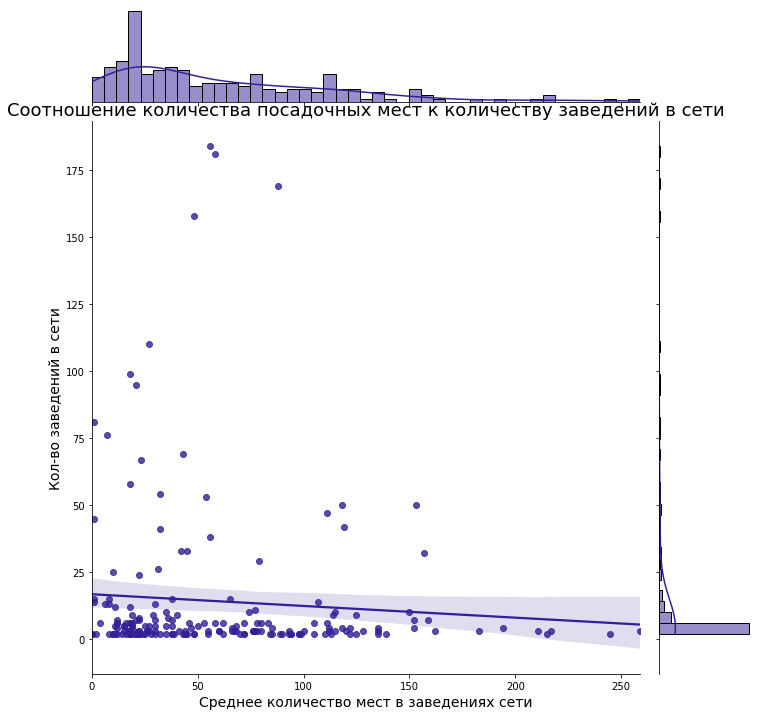

In [34]:
sns.jointplot(x='number',
              y='chain',
              data=chain_seats,
              marginal_kws=dict(bins=45, rug=True),
              kind='reg', height=10,
              color='#341f97')
plt.xlabel('Среднее количество мест в заведениях сети', fontsize=14)
plt.ylabel('Кол-во заведений в сети', fontsize=14)
plt.title('Соотношение количества посадочных мест к количеству заведений в сети', fontsize=18);

Как правило в сетях действует до 20 заведений с количеством посадочных мест до 50. При этом существуют крупные сети вплоть до 180 заведений, количество мест в них как правило не превышает 50, как и в мелких сетях.

Распределение количества заведений и количества мест в заведениях сети нормальное, но с большим количеством выбросов. Размах количества заведений значительно меньше, чем размах количества посадочных мест.

<a id="seats"></a>
### Посадочные места

In [35]:
rest_seats = rest_data.groupby('object_type')['number'].mean().round().reset_index()

In [36]:
px.bar(rest_seats.sort_values(by='number'),
    x='object_type',
    y='number',
    title='Среднее количество мест',
    color_discrete_sequence = ['#ff9f43'],
    labels={'number': 'Кол-во мест',  'object_type': 'Тип заведения'},
    width=950, height=600)

Самые вместительные заведения - столовые и рестораны. Кафе вмещают в среднем около 40 посетителей.

У каждого типа заведения своя концепция:
- столовой нужно вместить максимальное количество посетителей, приходящих из соседних офисов на обед
- в ресторанах должно быть достаточно места для проведения масштабных мероприятий (банкеты, юбилеи, праздники, корпоративы) и в то же время важно наличие отдельных залов, чтобы во время банкета другие посетители тоже могли хорошо провести время, также концептуально ресторан - место с качественной пищей, где на приготовление уходит значительное количество времени, поэтому средний посетитель проводит здесь больше времени, следовательно, требуется увеличенное количество посадочных мест
- в кафе и барах важна атмосфера и б*о*льшая камерность по сравнению с другими типами заведений, поэтому в них не такое большое количество мест
- закусочные ориентированы на работу на вынос, поэтому в них предусмотрено минимальное количество посадочных мест.

<a id="volume"></a>
### Насыщенность заведениями по улицам

Посмотрим на самые насыщенные заведениями районы Москвы и напротив, самые обделенные.

In [37]:
rest_data['street'] = rest_data['address'].str.extract(',(.*?), дом', expand=False).str.strip()

In [38]:
top_10_streets = (rest_data
                    .groupby('street')
                    .agg({'number':'count'})
                    .reset_index()
                    .sort_values(by='number', ascending=False)
                    .head(10))

In [39]:
px.bar(top_10_streets,
    x='street',
    y='number',
    color_discrete_sequence = ['#ff9f43'],
    title='Топ 10 улиц по количеству заведений',
    labels={'number': 'Кол-во заведений',  'street': 'Название улицы'},
    width=950, height=600)

Большое количество заведений расположено вдоль протяженных московских хорд, направленных в различные стороны света. Также есть две крупные точки притяжения: Москва-Сити и стадион ЦСКА. Также стоит отметить, что на хордах ЮЗАО и ЗАО больше заведений чем на хордах других направлений.

Большое количество заведений на хордах можно объяснить протяженностью этих улиц и проспектов. В Москва-Сити большое количество офисов и торговых центров, также это в целом мощная точка притяжения большого количества людей. Рядом со стадионом ЦСКА расположен очень крупный торговый центр "Авиапарк", который считается крупнейшим в Европе.

In [40]:
rest_streets = (rest_data
                  .groupby('street')
                  .agg({'number':'count'})
                  .reset_index()
                  .sort_values(by='number', ascending=False))
print(f"Количество улиц с единственным заведением: {len(rest_streets[rest_streets['number'] == 1])}")

Количество улиц с единственным заведением: 606


In [41]:
rest_streets[rest_streets['number'] == 1].sample(20, random_state=10)

,street,number
160,3-й проезд Подбельского,1
1685,улица Жуковского,1
964,Производственная улица,1
1202,Федоскинская улица,1
1199,Учинская улица,1
563,Интернациональная улица,1
432,Выползов переулок,1
1489,"поселение Сосенское, посёлок Коммунарка, микро...",1
1903,улица Саляма Адиля,1
82,2-й Балтийский переулок,1


Какой-то четкой закономерности расположения улиц с единственным заведением общественного питания не наблюдается. Можно заметить, что это либо улицы в пригородах Москвы, либо за пределами МКАД, либо улицы, расположенные рядом с железнодорожными путями - однако эти черты не покрывают все разнообразие улиц с одним заведением на них.

<a id="top_streets_capacity"></a>
### Вместительность заведений популярных улиц

In [42]:
fig = ff.create_distplot([rest_streets['number']], ['street'], colors = ['#222f3e'])
fig.update_layout(title_text='Распределение количества заведений по улицам',
    showlegend=False,
    autosize=False,
    width=900, height=600)

В большинстве случаев на одной улице располагается не более 3 объектов. Рассмотрим популярные улицы, будем считать таковыми улицы с более чем 10 заведениями.

In [43]:
fig = (ff.create_distplot([rest_data[(rest_data['street']
                                        .isin(rest_streets[rest_streets['number'] > 10]['street'])) &
                                     (rest_data['number'] < 400)]['number']], ['number'], colors = ['#222f3e']))
fig.update_layout(title_text='Распределение количества мест на улицах с большим количеством заведений',
    showlegend=False,
    autosize=False,
    width=900, height=600)

Наибольшую долю составляют заведения без посадочных мест. Вероятно, это точки, работающие на вынос (кофе с собой, шаурма и подобные). Дальше идут заведения с большей вместимостью. При этом видны всплески заведений с вместимостью кратной 10, что примерно напоминает нам деление объектов по типам. Таким образом, на улице с большим количеством заведений вероятнее всего соседствуют объекты разного типа, при этом стоит ожидать наличие нескольких точек, работающих на вынос.

<a id="sum_up"></a>
## Общий вывод

Проведен анализ рынка общественного питания Москвы. Изначально в базе обнаружено 225 записей с одинаковым названием и адресом. Дубликаты удалены, оставлены записи с максимальным id, как наиболее актуальные. Названия топ-30 сетей по количеству заведений унифицированы, чтобы не считать варианты названия одной сети за разные. Сети с единственным заведением удалены.

В результате анализа оказалось, что наиболее многочисленным типом объектов общественного питания Москвы является кафе - **39,5%**. Такой формат жизнеспособен на московском рынке, однако следует учитывать высокую конкуренцию.

Доля сетевых кафе составила **21%**, что практически в **2** раза меньше доли сетевых заведений быстрого обслуживания. При этом для большинства сетей характерно количество заведений до **25** с количеством посадочных мест до **50**. Среднее количество посадочных мест в кафе - **40**.

Улицы с большим количеством заведений это протяженные хорды, направленные в различные стороны света. Также есть две крупные точки притяжения: Москва-Сити и стадион ЦСКА. При этом на хордах ЮЗАО и ЗАО больше заведений чем на хордах других направлений. Улицы с единственным заведением разбросаны по всей Москве. Некоторые примеры расположения таких улиц: вблизи железнодорожных путей, за пределами МКАД или в пригородах Москвы.

Если взглянуть на типичную вместимость заведений на улицах с большим количеством точек питания, то можно заметить, что чем меньше вместимость объекта, тем больше таких объектов встречается. Чаще всего встречаются заведения без посадочных мест, работающие на вынос. Дальше вероятность убывает с шагом вместимости в 10 человек.

Таким образом, идея открыть кафе в Москве имеет ряд преимуществ:
- доля кафе самая многочисленная, значит спрос на такой формат высок
- доля сетевых кафе невысока, значит отдельные, несетевые заведения, успешно существуют
- роботы официанты - хороший ход для привлечения посетителей на насыщенном рынке, возможность занять новую нишу и укрепиться в направлений.

Стоит также учитывать следующие моменты:
- большая доля кафе - высокая конкуренция
- по вместимости кафе конкурирует также и с другими видами заведений, поэтому стоит внимательно подходить к выбору локации, чтобы поток посетителей не перешел в соседнее заведение-конкурент

Открывать кафе рекомендуется вблизи точек притяжения (московские хорды, стадион ЦСКА, ТЦ "Авиапарк", Москва-Сити и т.п.). Вместимость не должна превышать 50 мест. Можно предусмотреть работу на вынос, для привлечения клиентов, которые спешат и не планируют задерживаться в кафе.